# Data Loading and Quick Look at the Structure

In [4]:
import pandas as pd
import random

random.seed(42)      # We set the random seed to some constant number for reproducible results

train_data = pd.read_csv("/content/vaccine_train_set.csv").drop(columns=["Unnamed: 0"])
validation_data = pd.read_csv("/content/vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])

In [77]:
train_data.head()    # 0 = Neutral, 1 = Anti-Vax, 2 = Pro-Vax

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


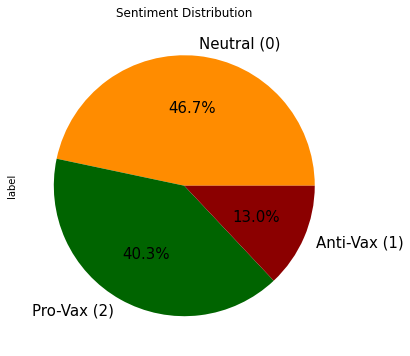

In [5]:
label_sentiments = {0: "Neutral (0)", 1: "Anti-Vax (1)", 2: "Pro-Vax (2)"}   # Make a dictionary mapping each label to its sentiment
plot = train_data['label'].value_counts().rename(index=label_sentiments).plot(kind='pie',figsize=(6,6), fontsize=15, colors=['darkorange','darkgreen','darkred'], title='Sentiment Distribution', autopct='%1.1f%%')

# Data Exploration

Let's see visualize the most frequent words in our training data.

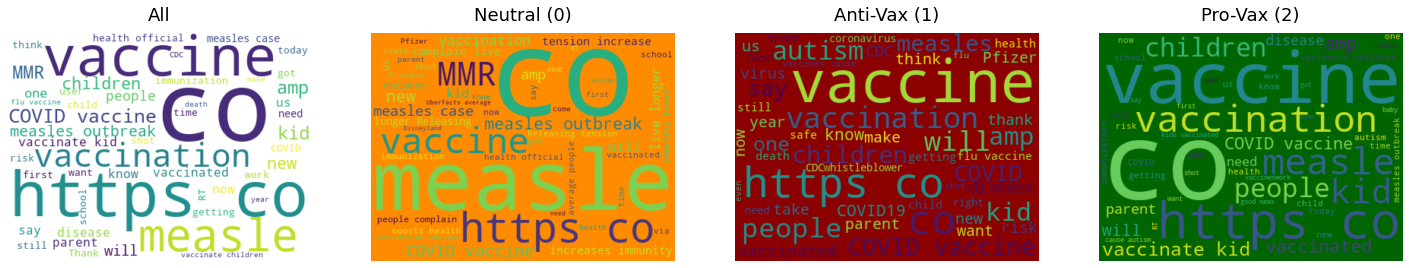

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

exploration_data = train_data.copy()    # Get a copy of the training data

all_tweets = " ".join(i for i in exploration_data['tweet'])
neutral_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 0])
negative_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 1])
positive_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 2])

wordcloud_all = WordCloud(max_words=50, height=300, background_color = 'white', stopwords = stopwords).generate(all_tweets)
wordcloud_neutral = WordCloud(max_words=50, height=300, background_color = 'darkorange', stopwords = stopwords).generate(neutral_tweets)
wordcloud_negative = WordCloud(max_words=50, height=300, background_color = 'darkred', stopwords = stopwords).generate(negative_tweets)
wordcloud_positive = WordCloud(max_words=50, height=300, background_color = 'darkgreen', stopwords = stopwords).generate(positive_tweets)

plt.figure(figsize = (25,30))
for i, wordcloud, title in [(1, wordcloud_all, 'All'), (2, wordcloud_neutral, 'Neutral (0)'), (3, wordcloud_negative, 'Anti-Vax (1)'), (4, wordcloud_positive, 'Pro-Vax (2)')]:
    plt.subplot(1,4,i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize = 18, y = 1.03)
    plt.axis("off")
plt.show()

The above visualizations don't look very informative. Firstly, there's a high overlap of individual words between the different categories. This is quite expected considering that even strong words like 'autism' can appear in both Anti-Vax and Pro-Vax tweets as 'vaccines cause autism' and 'vaccines don't cause autism' respectively, hence n-grams like bigrams would probably be much more informative than individual words. Secondly, there's quite some noise in our data, like links (https), that appear too often in our tweets and don't really offer any insights, therefore we'd probably have to clean our data before feeding them to our classification algorithms.

Now let's try to find and visualize the types of noise tweets can possibly have, like:
- tags (@)
- links (http,https,www)
- hashtags (some could be useful though)
- emojis
- emoticons :-)

In [7]:
import re
%pip install emoji
import emoji

def find_urls(tweet):
    """
    Searches for urls (http,https,www) in a tweet .
    """
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return re.search(url_pattern,tweet)

def find_hashtags(tweet):
    """
    Searches for hashtags (#) in a tweet.
    """
    hashtag_pattern = re.compile(r'#(\w+)')
    return re.search(hashtag_pattern,tweet)

def find_tags(tweet):
    """
    Searches for tags (@) in a tweet.
    """
    tag_pattern = re.compile(r'@[^\s]+')
    return re.search(tag_pattern,tweet)

def find_emojis(tweet):
    """
    Searches for emojis in a tweet.
    """
    emoji_pattern = emoji.get_emoji_regexp()
    return re.search(emoji_pattern,tweet)

     |████████████████████████████████| 170 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=0629533d5ce08345936c6c8baf76c95bc6f72b19eed1263a7c9299e4ddf79f07
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


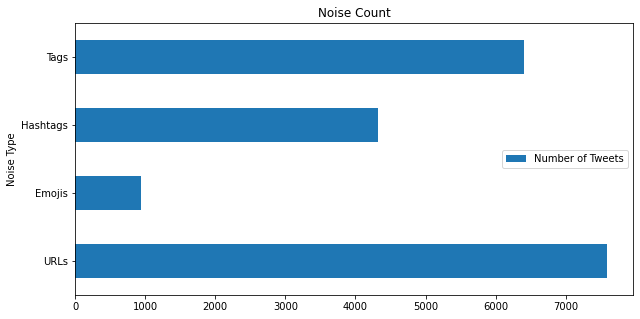

In [8]:
urls = exploration_data['tweet'].apply(find_urls).notnull().sum()
emojis = exploration_data['tweet'].apply(find_emojis).notnull().sum()
hashtags = exploration_data['tweet'].apply(find_hashtags).notnull().sum()
tags = exploration_data['tweet'].apply(find_tags).notnull().sum()
df_noise = pd.DataFrame({'Noise Type': ['URLs', 'Emojis', 'Hashtags', 'Tags'], 'Number of Tweets': [urls, emojis, hashtags,tags]})
df_noise.plot.barh(x='Noise Type', y='Number of Tweets',figsize=(10,5), title='Noise Count');

# Data Preparation

## (Task-Specific) Noise Removal

We create custom transformers for each preparation step in order to create preparation pipelines and later treat our preparation steps as hyperparameters for fine-tuning our best model.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class URLRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the urls from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the urls in all the tweets
            - None: Does nothing. No urls are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            url_pattern = re.compile(r'http\S+|www\S+|https\S+')
            return X_rem.apply(lambda tweet: url_pattern.sub(r'',tweet))
        return X
    
class HashtagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the hashtags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the hashtags in all the tweets.
            - None: Does nothing. No hashtags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            hashtag_pattern = re.compile(r'#(\w+)')
            return X_rem.apply(lambda tweet: hashtag_pattern.sub(r'',tweet))
        return X

class TagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the tags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the tags in all the tweets.
            - None: Does nothing. No tags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            tag_pattern = re.compile(r'@[^\s]+')
            return X_rem.apply(lambda tweet: tag_pattern.sub(r'',tweet))
        return X

class EmojiRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the emojis from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the emojis in all the tweets.
            - Convert: Converts all the emojis to their text representations.
            - None: Does nothing. No emojis are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            if self.strategy == 'Remove':
                emoji_pattern = emoji.get_emoji_regexp()
                return X_rem.apply(lambda tweet: emoji_pattern.sub(r'',tweet))
            elif self.strategy == 'Convert':
                return X_rem.apply(lambda tweet: emoji.demojize(tweet))
        return X

## Normalization

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
Stopwords = set(stopwords.words('english')) # We save them in this variable to speed up the lambda function for removing stopwords. It also helps speed up gridSearch later.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

class LowercaseConverter(BaseEstimator, TransformerMixin):
    """
    Converts (or not) all tweets to lowercase.
    """
    def __init__(self, strategy='Convert'):
        """
        Available Strategies:
            - Convert: Converts all tweets to lowercase.
            - None: Does nothing. No lowercase conversion takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.str.lower()
        return X      

class PunctuationRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the punctuation from all tweets.
    (In fact, it replaces it with empty space which comes 
    in handy when we convert emojis to their text representations)
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the punctuation in all the tweets.
            - None: Does nothing. No punctuation is removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            punctuation_pattern = re.compile(r'[^\w\s]')
            return X_rem.apply(lambda tweet: punctuation_pattern.sub(r' ',tweet))
        return X
    
class StopwordRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the stopwords from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the stopwords in all the tweets.
            - None: Does nothing. No stopwords are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.apply(lambda tweet: " ".join([word for word in str(tweet).split() if word not in Stopwords]))
        return X    
    
class InflectedFormHandler(BaseEstimator, TransformerMixin):
    """
    Handles the inflected forms of words by using either Stemming or Lemmatization.
    """
    def __init__(self, strategy='Stemming'):
        """
        Available Strategies:
            - Stemming: Uses a stemmer.
            - Lemmatization: Uses a lemmatizer.
            - None: Does nothing. No inflected form handling takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            if self.strategy == 'Stemming':
                return X.apply(lambda tweet: " ".join([stemmer.stem(word) for word in tweet.split()]))
            elif self.strategy == 'Lemmatization':
                return X.apply(lambda tweet: " ".join([lemmatizer.lemmatize(word, pos='v') for word in tweet.split()]))
        return X    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Vectorization

Load and prepare the Word-Embeddings for usage.

In [11]:
import numpy as np

!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip /content/glove.twitter.27B.zip

# Twitter Word-Embedding Files:
files = [(25,'/content/glove.twitter.27B.25d.txt'), (50,'/content/glove.twitter.27B.50d.txt'), (100,'/content/glove.twitter.27B.100d.txt'), (200,'/content/glove.twitter.27B.200d.txt')]

# Create a Dictionary of Word-Embeddings -for each file-
all_embeddings_dict = {}                                                        # A dictionary of 4 dictionaries. One for each of the 4 possible dimensions.
for dimensions, filename in files:
    with open(filename, 'r', encoding='utf-8') as file:
        embeddings_dict = {}                                                    # A dictionary of -this file's- word-embeddings
        for line in file:
            split_line = line.split()                                           # Each line is of the form: 'word  vector_value1  vector_value2  ....  vector_value25'
            word = split_line[0]
            vector = np.array(split_line[1:], dtype=np.float64)
            embeddings_dict[word] = vector
        all_embeddings_dict[dimensions] = embeddings_dict                       

--2021-12-15 12:52:06--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-12-15 12:52:07--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.19MB/s    in 4m 50s  

2021-12-15 12:56:56 (5.01 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  /content/glove.twitter.27B.zip
  inflating: glove.twit

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

class Vectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorizes the data using Bag of Words, TF-IDF or Pre-Trained Word-Embeddings.
    """
    def __init__(self, strategy='BoW', ngram_range=(1,1), min_df=1, max_df=1.0, dimensions=None):
        """
        Available Strategies:
            - BoW: Bag of Words.
            - TF-IDF: TF-IDF,
            - Word-Embeddings: Pre-trained GloVe Twitter Word Embeddings.
        ngram_range: the ngram_range parameter e.g. ngrams=(1, 1)=only unigrams, (1, 2)=unigrams and bigrams
        min_df: minimum number of tweets a word must be present in to be considered a feature
        max_df: maximum number of tweets a word can be present in to be considered a feature
        dimensions: 25 or 50 or 100 or 200, depending on how many dimensions (i.e. which file) to use for the word-embeddings
        """
        self.strategy = strategy
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.vectorizer = None                  # Used only when strategy is either BoW or TF-IDF
        self.dimensions = dimensions
    def fit(self, X, y=None):
        """
        Initiates the vectorizer to the chosen method (bow or tfidf) and then only fits the vectorizer 
        on the data (no transform). This way we can 'fit_transform' on the training data and only call 
        'transform' on the validation data.
        """
        if self.strategy == 'BoW':
            self.vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        elif self.strategy == 'TF-IDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        # If strategy is 'Word-Embeddings', we don't do anything during 'fit'
        return self
    def transform(self, X):
        """
        Transforms the data using the -already fit- vectorizer of the class.
        """
        X_vec = X.copy()
        if self.strategy == 'BoW' or self.strategy == 'TF-IDF':
            X_vec =  self.vectorizer.transform(X_vec)
        else:
            # Initialize the all vectorized tweets to zeros
            X_vec = np.zeros((len(X),self.dimensions))
            # For each tweet in the dataset
            for index, tweet in enumerate(X):
                valid_words_num = 0                                                         # Number of words in this tweet that are in GloVe's vocabulary
                word_vectors = np.zeros(self.dimensions)
                # For each word in this particular tweet
                for word in tweet.split():
                    # If the word is the GloVe's vocabulary
                    if word in all_embeddings_dict[self.dimensions].keys():
                        valid_words_num += 1
                        # Add this word's vector to the whole tweet's vector (Vertically)
                        word_vectors = np.vstack((word_vectors,all_embeddings_dict[self.dimensions][word])) if valid_words_num > 1 else all_embeddings_dict[self.dimensions][word]
                # Get the mean over the 0 axis (i.e. one value per dimension)
                X_vec[index] = word_vectors.mean(axis=0) if valid_words_num > 1 else word_vectors
        return X_vec

## Convertion to Tensors

In [13]:
import torch

class Tensorizer(BaseEstimator, TransformerMixin):
    """
    Converts the numpy arrays to pytorch tensors.
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X): 
        X_vec = X.copy()
        # If BoW or TF-IDF was used for the vectorization, then X would now be a sparse matrix, so we convert back to dense ndarray
        if not isinstance(X_vec,np.ndarray):
             X_vec = X_vec.toarray()
        X_vec = torch.from_numpy(X_vec).float()
        return X_vec

# Model Selection and Training

In [14]:
import torch
import torch.nn as nn

torch.manual_seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, layers):
        """
        Initializes the pytorch model according to the 'layers' parameter.
        layers =  A list of tuples. Each tuple corresponds to a dense layer's dimensions
        and its activation function (if any). 
        For example,
        layers = [(12173,None),(264,'ReLU'),(3,'LogSoftmax')]
        means:
        - The first (input) layer is of size 12173 (this would be the number of features per datapoint)
          There is no activation function for the first layer, because we don't transform the input datapoint's
          features before passing them to the next layer.
        - The next (hidden) layer has 264 neurons and before passing the output of this layer to the next one,
          we pass them through the ReLU activation function to introduce non-linearity to our network.
        - The next (output) layer has 3 neurons (corresponding to each of possible labels for our data) and before
          returning the final prediction, we pass the outputs through the LogSoftmax activation function.
        Therefore, in the above case we'd end up with the following pytorch model: 
        NeuralNetwork(
        (layers):
            (0): Linear(in_features=12173, out_features=264, bias=True)
            (1): ReLU()
            (2): Linear(in_features=264, out_features=3, bias=True)
            (3): LogSoftmax(dim=1)
        """
        super(NeuralNetwork, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            layer_input_dim = layers[i][0]
            layer_output_dim = layers[i+1][0]
            layer_activation_function = layers[i+1][1]
            # Set the dense layer
            self.layers.append(nn.Linear(layer_input_dim, layer_output_dim))
            # Set the layer's activation function
            if layer_activation_function:
                if layer_activation_function == 'ReLU':
                    self.layers.append(nn.ReLU())
                elif layer_activation_function == 'LogSoftmax':
                    self.layers.append(nn.LogSoftmax(dim=1))
                elif layer_activation_function == 'Sigmoid':
                    self.layers.append(nn.Sigmoid())
                elif layer_activation_function == 'Tanh':
                    self.layers.append(nn.Tanh())
                elif layer_activation_function == 'LeakyReLU':
                    self.layers.append(nn.LeakyReLU(0.1))


    def forward(self, x):
        """
        Performs a forward propagation over the networks layers.
        """
        out = self.layers[0](x)
        for i in range(1,len(self.layers)):
            out = self.layers[i](out)
        return out

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def train_loop(dataloader, model, loss_fn, optimizer, device):
    """
    Performs a -single- training iteration (epoch) of the network over all the batches. That is, it performs a forward propagation, 
    computes the error, computes the metric scores (e.g. f1, precision etc) -over the training dataset- for later plotting and then
    updates the parameters using backpropagation. The update takes place per batch. The function returns the (avg. over the batches) 
    scores for each of the metrics on the validation dataset.
    """
    num_batches, sum_losses, sum_f1s, sum_precisions, sum_recalls = (len(dataloader),0,0,0,0)
    for (X, y) in dataloader:
        # Transfer tensors to the specified device
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred,y)

        # Compute metric scores
        sum_losses += loss.item()
        sum_f1s += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
        sum_precisions += precision_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
        sum_recalls += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return sum_losses/num_batches, sum_f1s/num_batches, sum_precisions/num_batches, sum_recalls/num_batches

def validation_loop(dataloader, model, loss_fn, device):
    """
    Performs a -single- validation iteration (epoch) of the network over all the batches. That is, it performs a forward propagation
    to make the predictions and compute the metric scores -over the validation dataset- for later plotting. We don't update any parameters
    because there's no training taking place, only prediction, to evaluate our model after each epoch. The predictions also take place per
    batch. The function returns the (avg. over the batches) scores for each of the metrics on the validation dataset.
    """
    num_batches, sum_losses, sum_f1s, sum_precisions, sum_recalls = (len(dataloader),0,0,0,0)
    with torch.no_grad():
        for X, y in dataloader:
            # Transfer tensors to the specified device
            X = X.to(device)
            y = y.to(device)
            
            # Compute prediction
            pred = model(X)

            # Compute metric scores
            sum_losses += loss_fn(pred,y).item()
            sum_f1s += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
            sum_precisions += precision_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
            sum_recalls += recall_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)

    return sum_losses/num_batches, sum_f1s/num_batches, sum_precisions/num_batches, sum_recalls/num_batches

def train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device):
    """
    Performs the training of the network and evaluation of it over each epoch. For each epoch, it first performs a train_loop to update
    its parameters and then evaluates the network by performing a validation loop. For each epoch, it saves the metric scores for each
    dataset its corresponding dictionary and metric list. The function returns the train_scores and validation_scores per epoch for
    later plotting.
    """
    train_scores = {'loss':[], 'f1':[], 'precision':[], 'recall':[]}
    validation_scores = {'loss':[], 'f1':[], 'precision':[], 'recall':[]}
    for t in range(epochs):
        # Update the network's parameters
        train_loss, train_f1, train_precision, train_recall = train_loop(train_dataloader, model, loss_func, optimizer, device)

        # Evaluate the updated model on the validation set 
        validation_loss, validation_f1, validation_precision, validation_recall = validation_loop(validation_dataloader, model, loss_func, device)

        # Save the training scores of this epoch
        train_scores['loss'].append(train_loss)
        train_scores['f1'].append(train_f1)
        train_scores['precision'].append(train_precision)
        train_scores['recall'].append(train_recall)
        
        # Save the validation scores of this epoch
        validation_scores['loss'].append(validation_loss)
        validation_scores['f1'].append(validation_f1)
        validation_scores['precision'].append(validation_precision)
        validation_scores['recall'].append(validation_recall)

    return train_scores, validation_scores

def plot_scores(train_scores,validation_scores,epochs,title):
    """
    Plots the training and validation scores per epoch. That is, the loss (as specified by the loss function used during training) over the
    epochs, the f1 scores over the epochs, the precision over the epochs and the recall over the epochs, for each of the two datasets. 
    """
    plt.figure(figsize = (20,4))
    for i,metric in enumerate(['loss','f1','precision','recall']):
        plt.subplot(1,4,i+1)
        plt.plot(range(1,epochs+1), train_scores[f'{metric}'], label = 'Training')
        plt.plot(range(1,epochs+1), validation_scores[f'{metric}'], label = 'Validation')
        plt.ylabel(f'{metric}', fontsize = 12)
        plt.xlabel('epoch', fontsize = 12)
        plt.title(f'{metric} over epochs', fontsize = 12, y = 1.03)
        plt.legend()
    plt.suptitle(title,fontsize=12)
    plt.tight_layout()

Prepare the Data

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

# We use the best preparation pipeline we found in experiment (i).
preparation_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover(strategy=None)),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover(strategy='Remove')),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover(strategy=None)),
        ('inflected_forms', InflectedFormHandler(strategy=None)),
        ('vectorization', Vectorizer(strategy='Word-Embeddings', dimensions=200)),
        ('tensorizer', Tensorizer())
    ])

# Copy the data
X_train = train_data.copy()['tweet']
y_train = train_data.copy()['label']
X_validation = validation_data.copy()['tweet']
y_validation = validation_data.copy()['label']     

# Preprocess the data
X_train = preparation_pipeline.fit_transform(X_train)
X_validation = preparation_pipeline.transform(X_validation)

# Preprocess the labels
y_train = torch.tensor(y_train.values).long()
y_validation = torch.tensor(y_validation.values).long()

#Initialize dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

validation_dataset = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)

print(X_train.shape, type(X_train))
print(X_validation.shape, type(X_validation))
print(y_train.shape, type(y_train))
print(y_validation.shape, type(y_validation))

torch.Size([15976, 200]) <class 'torch.Tensor'>
torch.Size([2282, 200]) <class 'torch.Tensor'>
torch.Size([15976]) <class 'torch.Tensor'>
torch.Size([2282]) <class 'torch.Tensor'>


Let's see how the **Learning Rate** affects our training

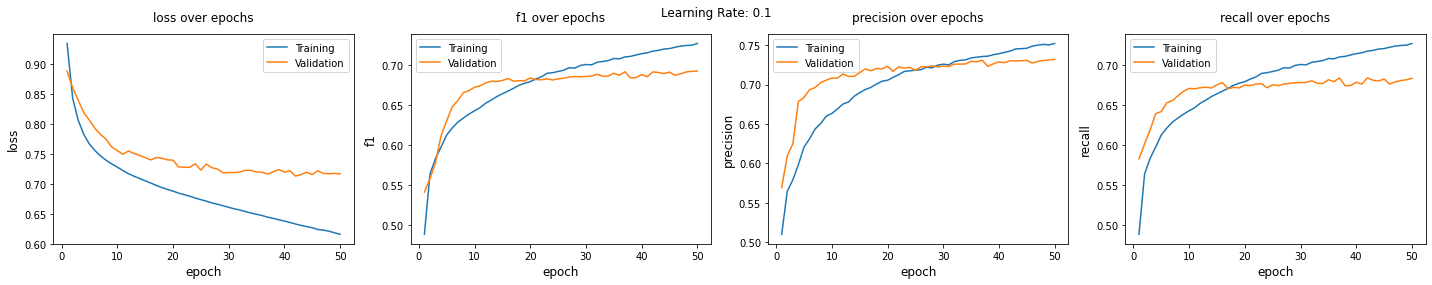

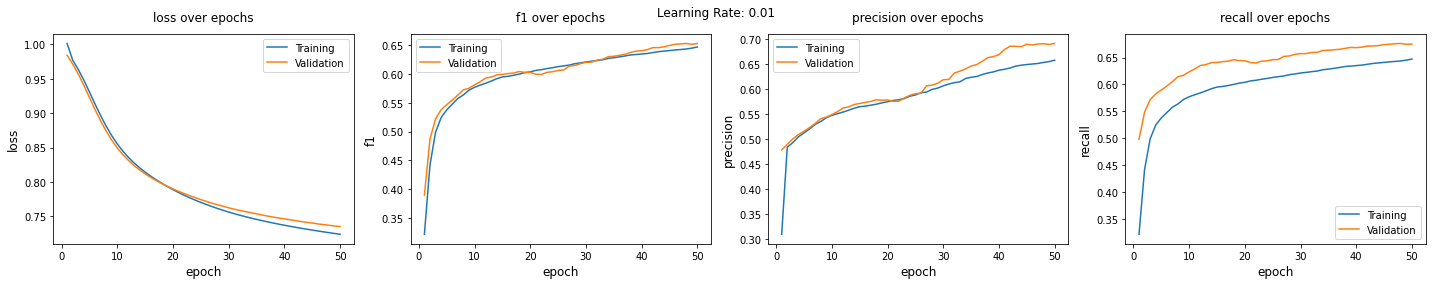

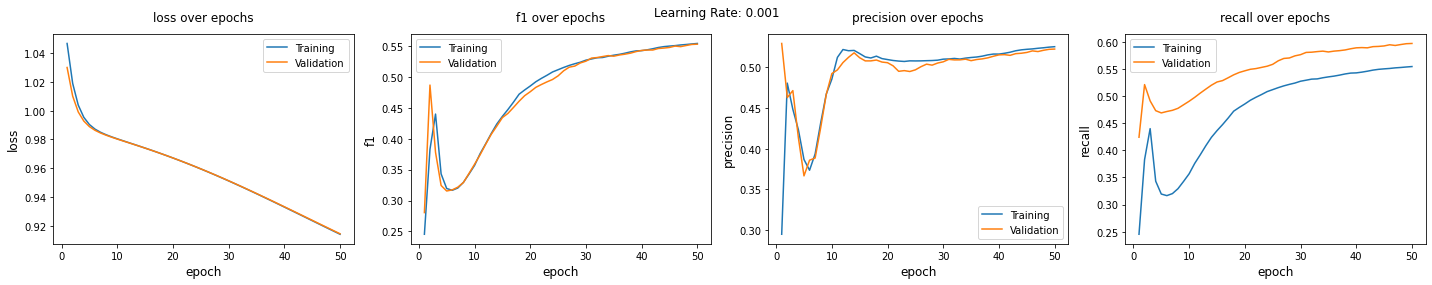

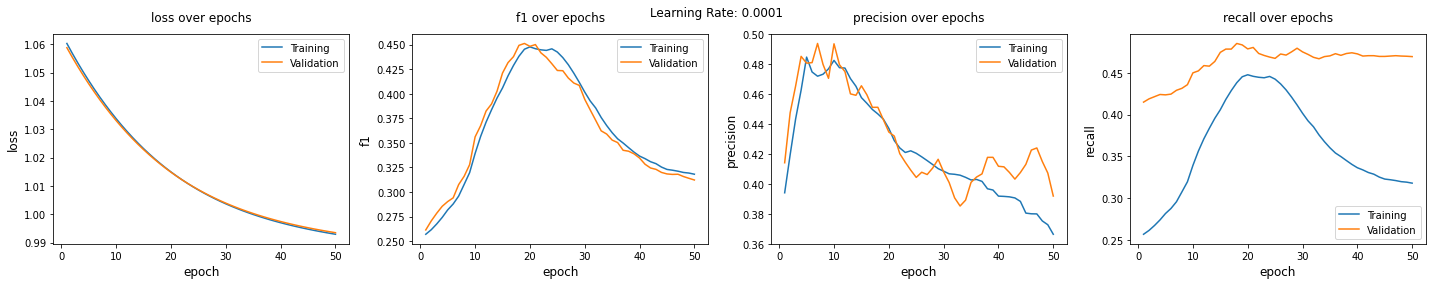

In [ ]:
# Define hyperparameters (except number of hidden layers)
lrs = [0.1,0.01,0.001,0.0001]
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
layers = [(X_train.shape[1],None),(64,'ReLU'),(3,'LogSoftmax')]

for i, lr in enumerate(lrs):
    #Initialize model, loss, optimizer
    model = NeuralNetwork(layers).to(device)
    loss_func = nn.NLLLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Learning Rate: {lr}')

Similarly to experiment (ii), a very large value for the learning rate leads to overfitting whereas a very small one leads to underfitting. However, the optimal learning rate is now around 0.01 and not 0.001 (at least for SGD, cause the other optimizers are probably going to have different optimal values). This is probably because of the small number of features that the word-embeddings provide us with.

Let's see how the **number of hidden layers** affects our training

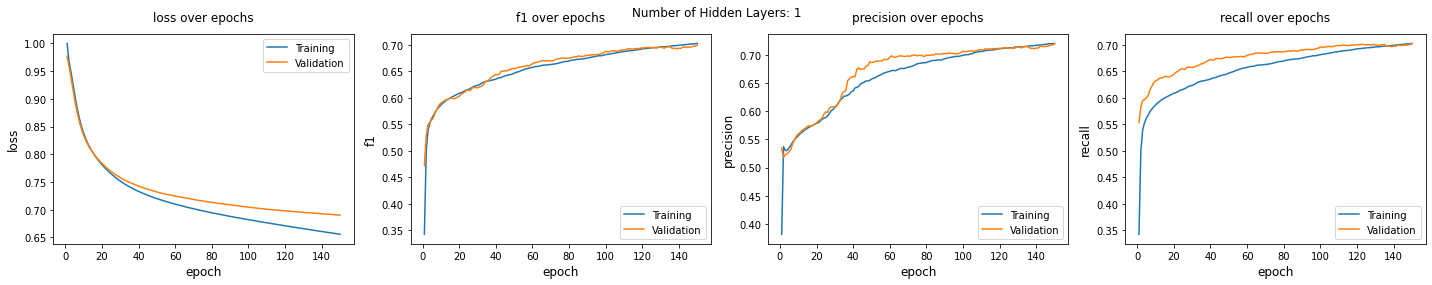

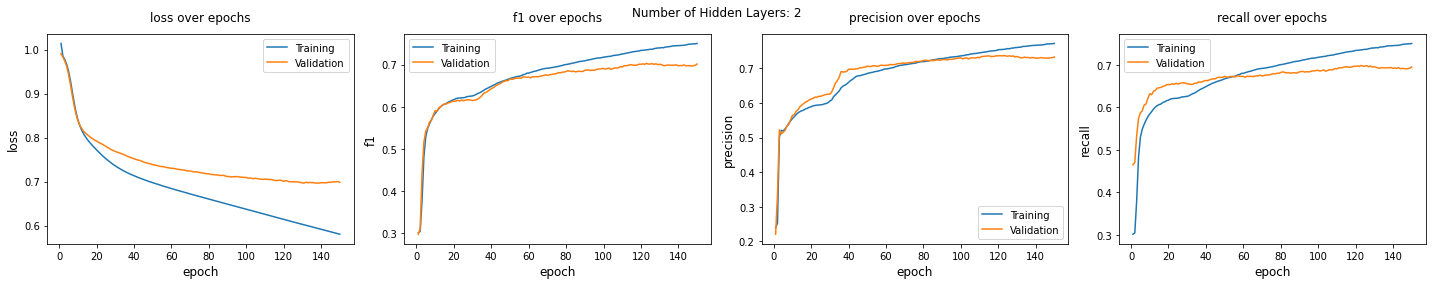

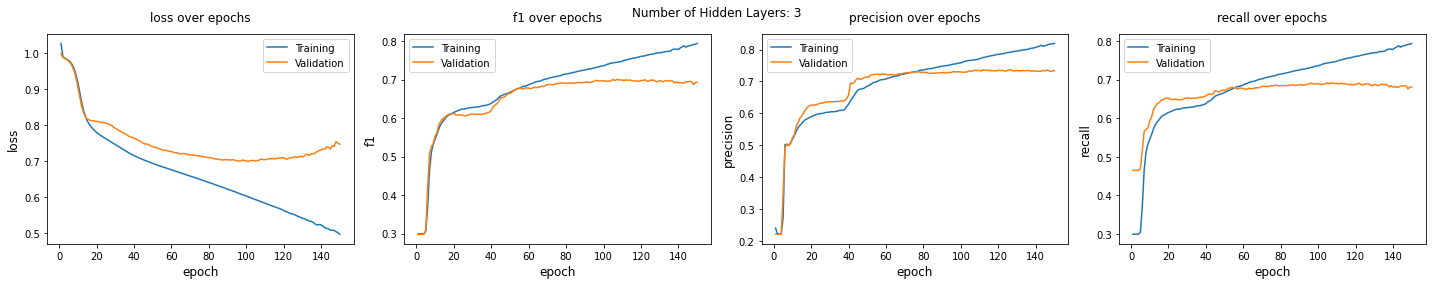

In [ ]:
# Define hyperparameters (except number of hidden layers)
lr = 0.01
epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The different models we're going to try out
layers1 = [(X_train.shape[1],None),(128,'ReLU'),(3,'LogSoftmax')]
layers2 = [(X_train.shape[1],None),(256,'ReLU'),(128,'ReLU'),(3,'LogSoftmax')]
layers3 = [(X_train.shape[1],None),(512,'ReLU'),(256,'ReLU'),(128,'ReLU'),(3,'LogSoftmax')]

for i, layers in enumerate([layers1,layers2,layers3]):
    #Initialize model, loss, optimizer
    model = NeuralNetwork(layers).to(device)
    loss_func = nn.NLLLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Number of Hidden Layers: {len(layers)-2}')

Just like in experiment (ii), the more the hidden layers the higher the variance of our model. Even though more layers allow for better fitting on the training data, our validation performance is way different. It looks like a single hidden layer generalizes better for the word-embeddings too. 

Let's see how the **Number of Neurons for each Layer** of our model affects our training/generalization.

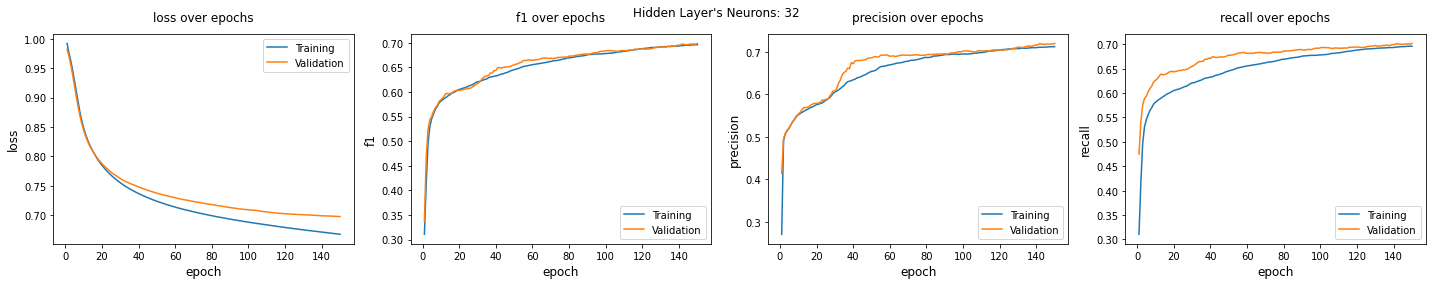

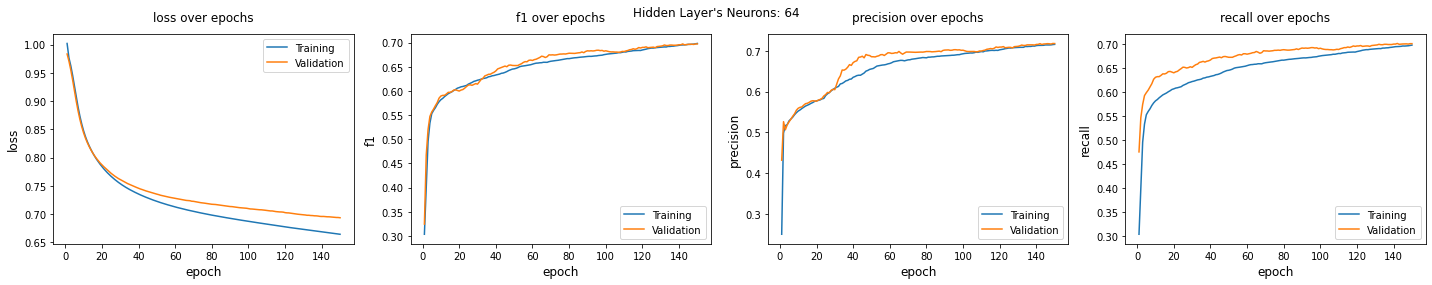

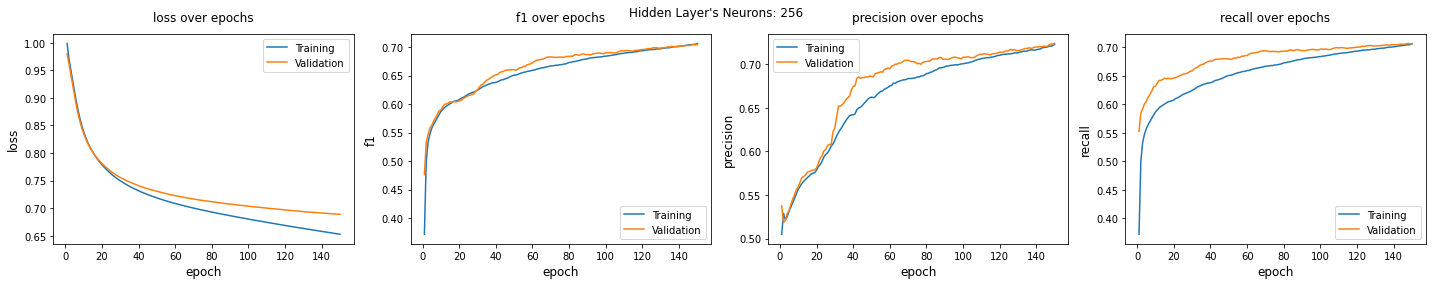

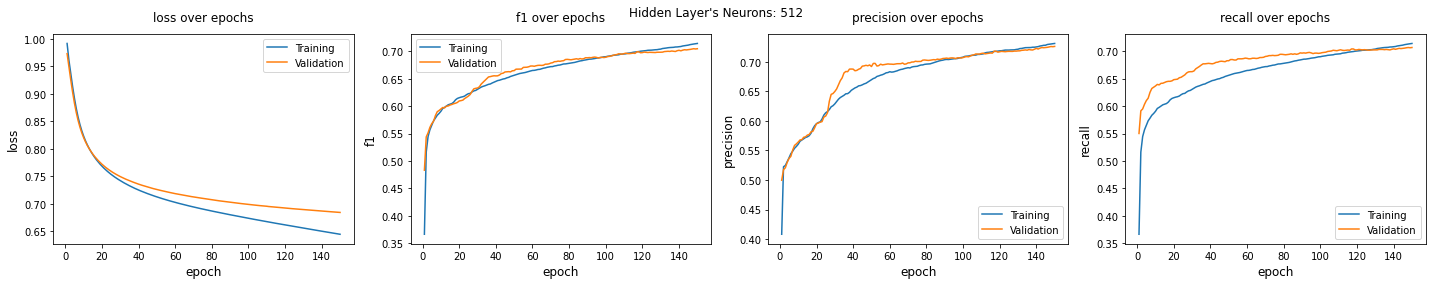

In [ ]:
# Define hyperparameters (except number of hidden layers)
lr = 0.01
epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The different models we're going to try out
layers1 = [(X_train.shape[1],None),(32,'ReLU'),(3,'LogSoftmax')]
layers2 = [(X_train.shape[1],None),(64,'ReLU'),(3,'LogSoftmax')]
layers3 = [(X_train.shape[1],None),(256,'ReLU'),(3,'LogSoftmax')]
layers4 = [(X_train.shape[1],None),(512,'ReLU'),(3,'LogSoftmax')]


for i, layers in enumerate([layers1,layers2,layers3,layers4]):
    #Initialize model, loss, optimizer
    model = NeuralNetwork(layers).to(device)
    loss_func = nn.NLLLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f"Hidden Layer's Neurons: {layers[1][0]}")

It looks like, given a single hidden layer for our neural network, the number of its hidden units doesn't affect the performance that much. However, this wouldn't be true obviously if we had a different configuration for the number of hidden layers, learning rate etc.

Let's see how the **Activation Functions -for the hidden layers-** affect our training/generalization.

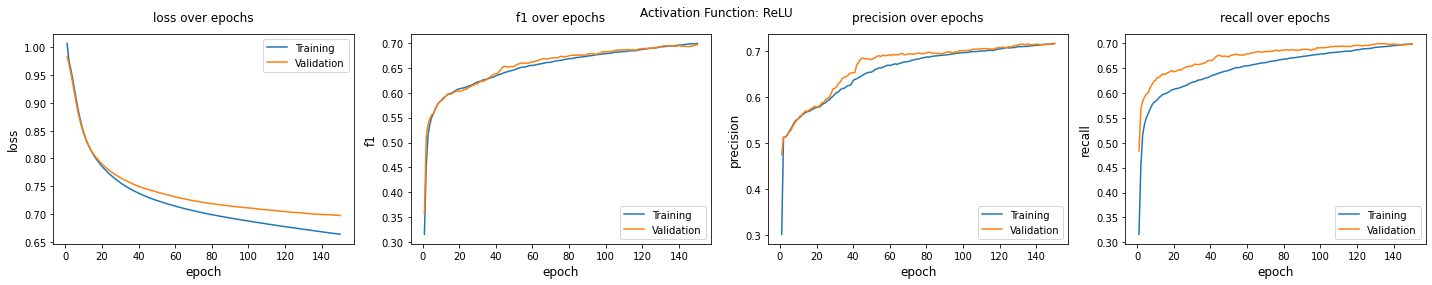

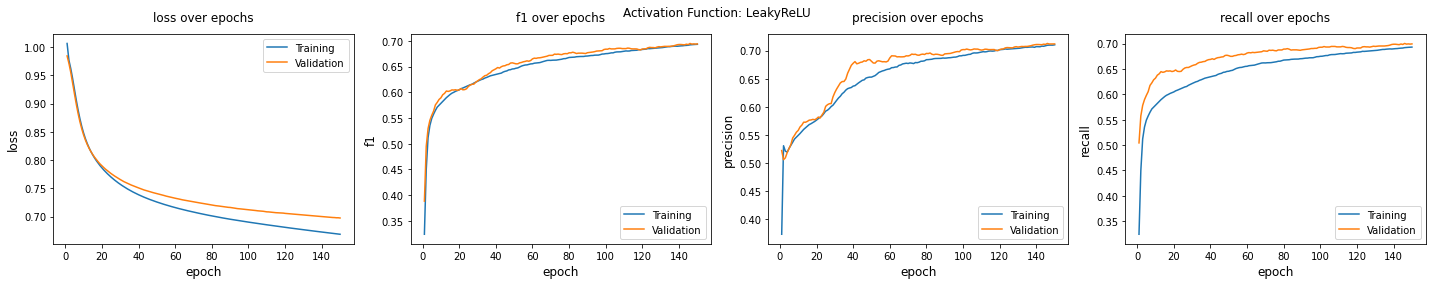

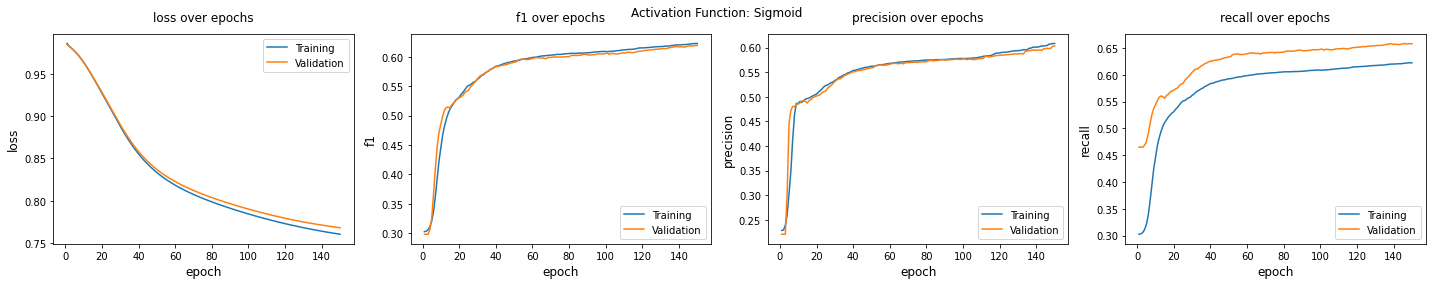

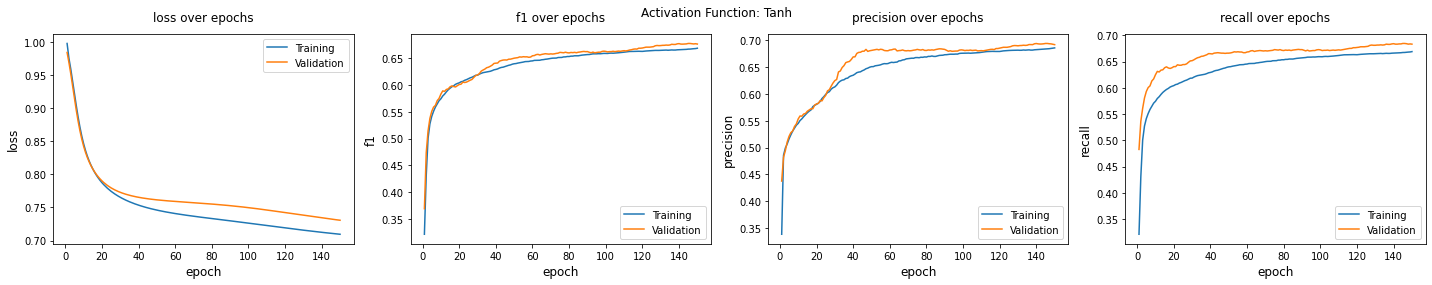

In [ ]:
# Define hyperparameters (except number of hidden layers)
lr = 0.01
epochs = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The different models we're going to try out
layers1 = [(X_train.shape[1],None),(64,'ReLU'),(3,'LogSoftmax')]
layers2 = [(X_train.shape[1],None),(64,'LeakyReLU'),(3,'LogSoftmax')]
layers3 = [(X_train.shape[1],None),(64,'Sigmoid'),(3,'LogSoftmax')]
layers4 = [(X_train.shape[1],None),(64,'Tanh'),(3,'LogSoftmax')]

for i, layers in enumerate([layers1,layers2,layers3,layers4]):
    #Initialize model, loss, optimizer
    model = NeuralNetwork(layers).to(device)
    loss_func = nn.NLLLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f"Activation Function: {layers[1][1]}")

Similarly to experiment (ii), the choice of activation function for a single hidden layer doesn't make that much of difference either. Sigmoid again doesn't look like the best choice and Tanh looks promising but currently kind of underfits our training data.

Let's see how the **Optimizer** affects our training/generalization.

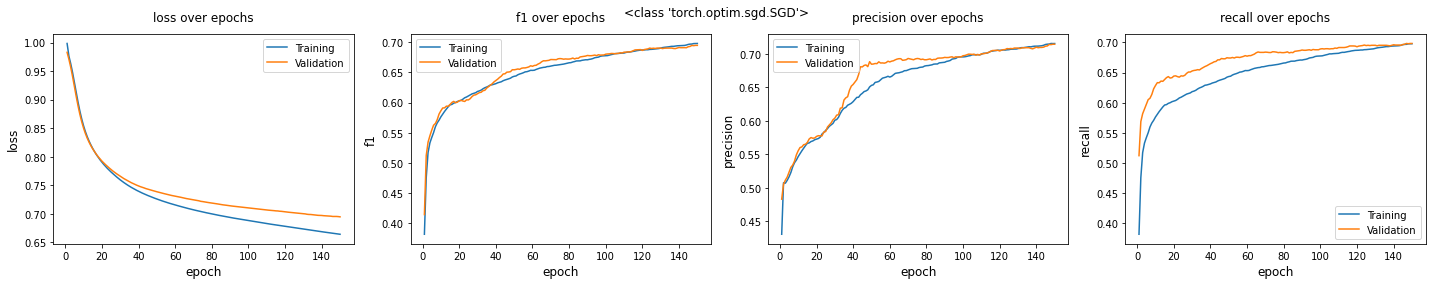

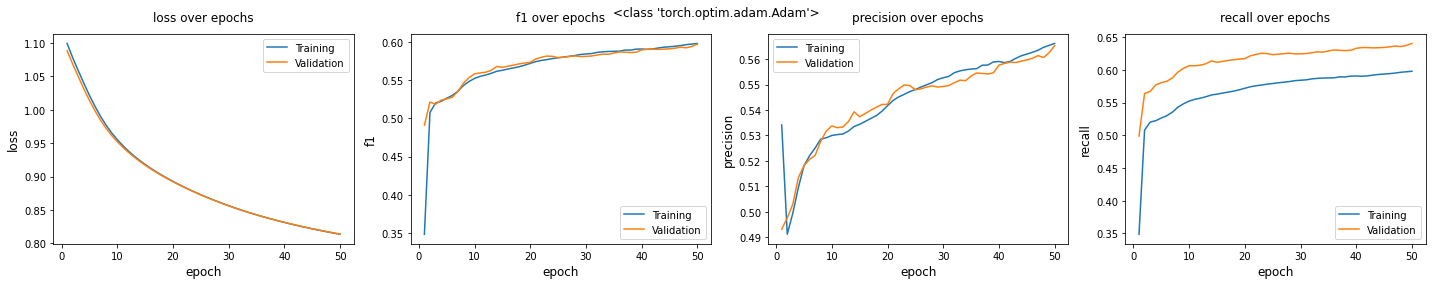

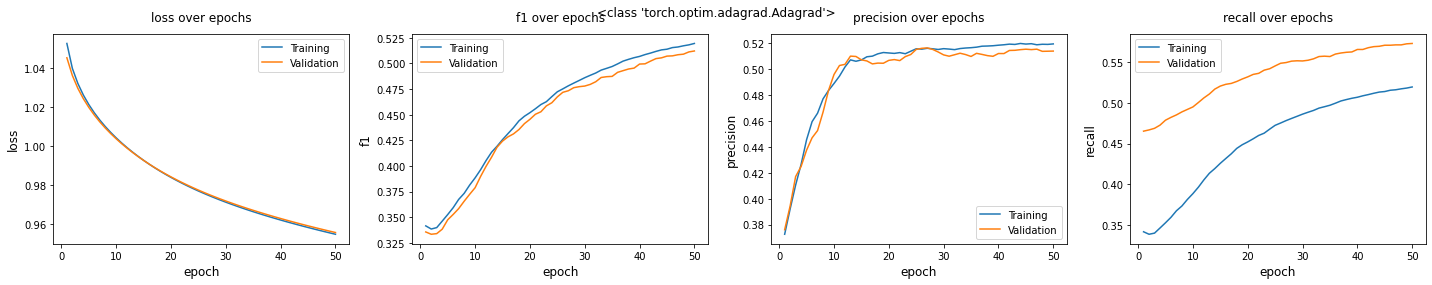

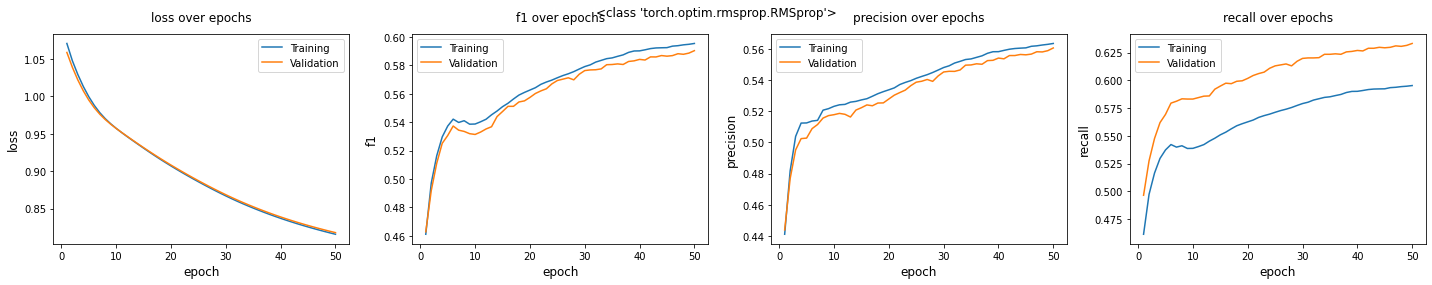

In [ ]:
# Define hyperparameters (except number of hidden layers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

layers = [(X_train.shape[1],None),(64,'ReLU'),(3,'LogSoftmax')]

#Initialize model, loss, optimizer
model = NeuralNetwork(layers).to(device)
loss_func = nn.NLLLoss().to(device)
optimizer1 = torch.optim.SGD(model.parameters(), lr=0.01)
# Train the Network
train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer1, 150, device)
# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,150,type(optimizer1))

#Initialize model, loss, optimizer
model = NeuralNetwork(layers).to(device)
loss_func = nn.NLLLoss().to(device)
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.00001)
# Train the Network
train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer2, 50, device)
# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,50,type(optimizer2))

#Initialize model, loss, optimizer
model = NeuralNetwork(layers).to(device)
loss_func = nn.NLLLoss().to(device)
optimizer3 = torch.optim.Adagrad(model.parameters(), lr=0.0001)
# Train the Network
train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer3, 50, device)
# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,50,type(optimizer3))

#Initialize model, loss, optimizer
model = NeuralNetwork(layers).to(device)
loss_func = nn.NLLLoss().to(device)
optimizer4 = torch.optim.RMSprop(model.parameters(), lr=0.00001)
# Train the Network
train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer4, 50, device)
# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,50,type(optimizer4))

Again plain SGD gives us the best performance out of the current configuration of our neural network. Probably a different configuration can work better with other optimizers and we're going to research that with individual (sub-)experiments next.

# Error Analysis (Evaluation of Best Model on the -Validation- Set)

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns

def plot_confusion_matrix(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(normalized_confusion_matrix, annot=True, cmap=plt.cm.gray, xticklabels=label_sentiments.values(), yticklabels=label_sentiments.values())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Validation Confusion Matrix')
    plt.show()
    
def print_wrong_examples(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    print("Examples of Wrong Classification in Validation:\n")
    for actual in label_sentiments.keys():
      for predicted in label_sentiments.keys():
        if actual != predicted and normalized_confusion_matrix[actual, predicted] > 0.2:       # Print only examples of label pairs with >20% confusion rate in the matrix
            print(f"\n'{label_sentiments[actual]}' Predicted as '{label_sentiments[predicted]}' - {round(100*normalized_confusion_matrix[actual, predicted])}% Confusion Rate:\n")
            for index,row in validation_data.loc[(y_validation == actual) & (predictions_validation == predicted)].head().iterrows():
                print(f"Index: {index} - Tweet: {row['tweet']}")
                
def print_top_ngrams(preparation_pipeline, model, N=6):         
    """
    Prints the most top N most correlated n-grams for each of the labels.
    (according to the learned θ parameters of the classification model)
    preparation_pipeline = The pipeline used to preprocess the data
                          (we need this for the ngrams used and the
                          feature_names of the vectorizer)
    model = This is the softmax regression model whose θ parameters we use
            to find the top n-grams
    N = The number of top n-grams to print e.g. the top 6 uni-grams and bi-grams
    """
    vectorizer = preparation_pipeline['vectorization'].vectorizer          # Get the vectorizer instance from the pipeline
    ngram_range = preparation_pipeline['vectorization'].ngram_range        # Get the value of the ngrams parameter in pipeline's vectorizer
    for label in label_sentiments.keys():
        indices = np.argsort(model.coef_[label])                           # Sort the model's learned coefficients θ (for each label) from lowest to highest and get their -indices-
        feature_names = np.array(vectorizer.get_feature_names())[indices]  # Get the words themselves (from the chosen vectorizer) corresponding to each index/coefficient
        print(f"\nIn '{label_sentiments[label]}' Tweets:")
        for n in range(ngram_range[0],ngram_range[1]+1):                   # Convert the ngram_range tuple to a range of numbers e.g. (1,3) = 1,2,3
            n_grams = [v for v in reversed(feature_names) if len(v.split(' ')) == n][:N]
            print("  Top {}-grams:\n      - {}".format(n,'\n      - '.join(n_grams))) 

def plot_roc_curve(y_validation,predictions_validation_probabilities):
    # Binarize the output
    y_true = label_binarize(y_validation, classes=[0, 1, 2])
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions_validation_probabilities.cpu().numpy()[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Train our best model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=200, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=3, bias=True)
    (3): LogSoftmax(dim=1)
  )
)


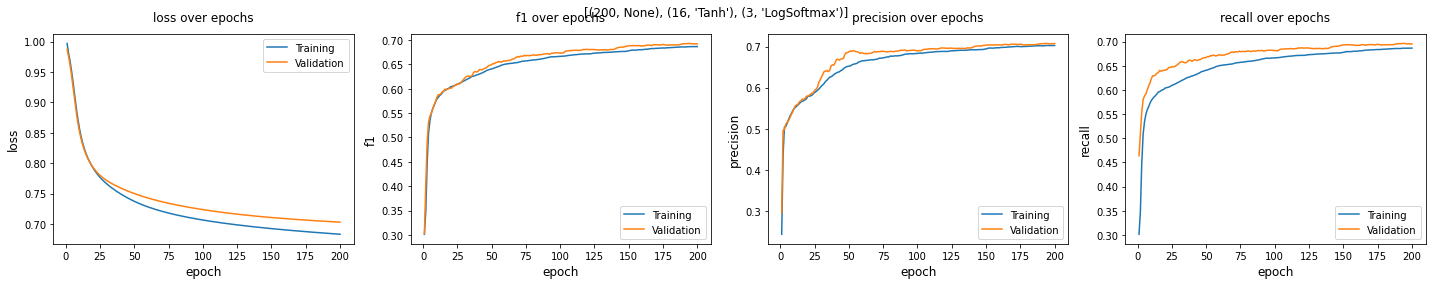

In [67]:
# Define hyperparameters (except number of hidden layers)
lr = 0.01
epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The different models we're going to try out
layers = [(X_train.shape[1],None),(16,'Tanh'),(3,'LogSoftmax')]

#Initialize model, loss, optimizer
final_model = NeuralNetwork(layers).to(device)
print(final_model)
loss_func = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(final_model.parameters(), lr=lr)

# Train the Network
train_scores, validation_scores = train_evaluate_network(train_dataloader, validation_dataloader, final_model, loss_func, optimizer, epochs, device)

# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,epochs,layers)

Predict on the validation set and do some error analysis

In [68]:
with torch.no_grad():
    # Transfer tensors to the specified device
    X = X_validation.to(device)
    
    # Compute the predictions
    predictions_validation_probabilities = final_model(X)                                   # Raw prediction probabilities (3 values per tweet)

predictions_validation = predictions_validation_probabilities.argmax(1).cpu().numpy()       # Single class predictions (1 value per tweet)

In [69]:
print(classification_report(y_validation, predictions_validation))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1065
           1       0.48      0.35      0.40       296
           2       0.63      0.76      0.69       921

    accuracy                           0.70      2282
   macro avg       0.64      0.61      0.62      2282
weighted avg       0.70      0.70      0.69      2282



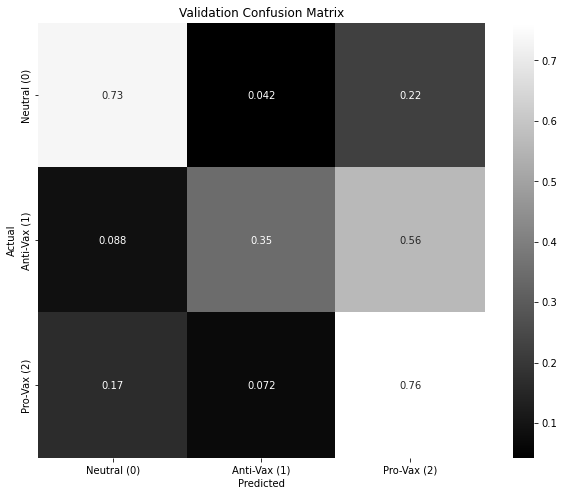

In [70]:
plot_confusion_matrix(y_validation,predictions_validation)

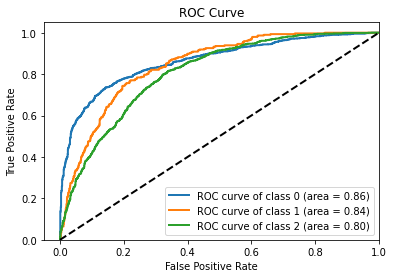

In [71]:
plot_roc_curve(y_validation,predictions_validation_probabilities)

As we explained in experiment (ii), Neural Networks allow us to find better correlations between the input and the output. However, in order to avoid overfitting we have employ techniques like dropout layers and weight regularization on the optimizers. Without these techniques, we have to greatly simplify our model to avoid overfitting. With the above simple neural network we weren't able to surpass the performance of the first exercise, but the performance compared to experiment (i), which also used word-embeddings, was better. That means that our Neural Networks were able to exploit the small number of features provided by the word-embeddings better than the softmax regressor did.

# Final Model Evaluation on the Test Set

Prepare the test data

In [72]:
# Get the test data (-------> change this to the path of the test dataset <--------)
test_data = pd.read_csv("/content/vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])
X_test = test_data.copy()['tweet']
y_test = test_data.copy()['label']

# Preprocess the test tweets. Only transform (using the best parameters) found during training. No fit.
X_test = preparation_pipeline.transform(X_test)

# Preprocess the labels
y_test = torch.tensor(y_test.values).long()

Predict on the test data

In [73]:
with torch.no_grad():
    # Transfer tensors to the specified device
    X = X_test.to(device)
    
    # Compute the predictions
    predictions_test_probabilities = final_model(X)                                   # Raw prediction probabilities (3 values per tweet)

predictions_test = predictions_test_probabilities.argmax(1).cpu().numpy()             # Single class predictions (1 value per tweet)

In [74]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1065
           1       0.48      0.35      0.40       296
           2       0.63      0.76      0.69       921

    accuracy                           0.70      2282
   macro avg       0.64      0.61      0.62      2282
weighted avg       0.70      0.70      0.69      2282



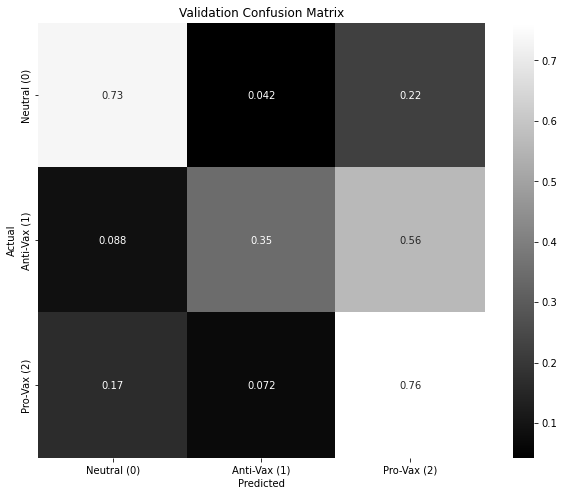

In [75]:
plot_confusion_matrix(y_test,predictions_test)

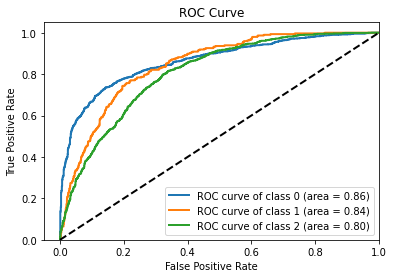

In [76]:
plot_roc_curve(y_test,predictions_test_probabilities)